# Store Item Demand Forecasting

## Questions:
You are given 5 years historical sales data from 50 different items at 10 different stores. Explore the dataset and answer the following questions: 
1. How is the sales trend and growth rate over the 5 years? 
2. How is the sales trend by different stores? 
3. How is the sales trend by different items? 
4. Do you have any recommendations for the growth of the stores? 
5. Bonus: predict 3 months of sales for these 50 different items at 10 stores.

## Dataset:
The storedata.csv contains 4 columns: 
1. date: Date of the sale data. There are no holiday effects or store closures. 
2. store: Store ID 
3. item: Item ID 
4. sales: Number of items sold at a particular store on a particular date.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import datetime
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM

import pickle

# 0 Data Exploration

In this part, we get familar with the data by doing the following:
<br> Check out the shape of data and the data types of each columns
<br> Check whether there is null or NAs
<br> The unique values and their counts in each columns
<br>in addition, we extract the 'year' and the 'month' feature from the column 'date' for the purpose of convience

In [2]:
data = pd.read_csv(r'data/raw/storedata.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [3]:
data.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [4]:
data.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [5]:
for i in data.columns:
    print(data[i].value_counts())
    print("-----------------------------------------")

2013-01-01    500
2016-05-11    500
2016-05-09    500
2016-05-08    500
2016-05-07    500
             ... 
2014-08-29    500
2014-08-28    500
2014-08-27    500
2014-08-26    500
2017-12-31    500
Name: date, Length: 1826, dtype: int64
-----------------------------------------
1     91300
2     91300
3     91300
4     91300
5     91300
6     91300
7     91300
8     91300
9     91300
10    91300
Name: store, dtype: int64
-----------------------------------------
1     18260
38    18260
28    18260
29    18260
30    18260
31    18260
32    18260
33    18260
34    18260
35    18260
36    18260
37    18260
39    18260
2     18260
40    18260
41    18260
42    18260
43    18260
44    18260
45    18260
46    18260
47    18260
48    18260
49    18260
27    18260
26    18260
25    18260
24    18260
3     18260
4     18260
5     18260
6     18260
7     18260
8     18260
9     18260
10    18260
11    18260
12    18260
13    18260
14    18260
15    18260
16    18260
17    18260
18    18260
19   

In [6]:
data.head()

date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10

Extract 'year' and 'month' from 'date'

In [7]:
df = data.copy()
df['year'] = df['date'].apply(lambda x: str(x)[:4])
df['month'] = df['date'].apply(lambda x: str(x)[:7])
df

date  store  item  sales  year    month
0       2013-01-01      1     1     13  2013  2013-01
1       2013-01-02      1     1     11  2013  2013-01
2       2013-01-03      1     1     14  2013  2013-01
3       2013-01-04      1     1     13  2013  2013-01
4       2013-01-05      1     1     10  2013  2013-01
...            ...    ...   ...    ...   ...      ...
912995  2017-12-27     10    50     63  2017  2017-12
912996  2017-12-28     10    50     59  2017  2017-12
912997  2017-12-29     10    50     74  2017  2017-12
912998  2017-12-30     10    50     62  2017  2017-12
912999  2017-12-31     10    50     82  2017  2017-12

[913000 rows x 6 columns]

# 1 How is the sales trend and growth rate over the 5 years?

## Sales trend

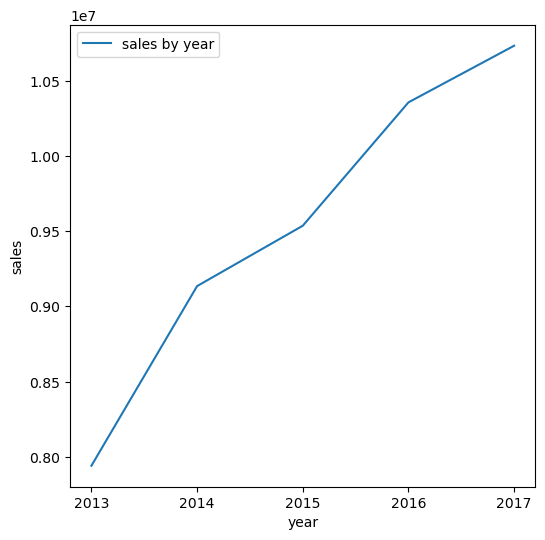

In [18]:
# Total Sales Trend By Year
x = list(df['year'].unique())
y_array = df[['sales','year']].groupby('year').sum().values
y = [i for item in y_array for i in item]
y_rate = [round(y[1]/y[0],3),round(y[2]/y[1],3),round(y[3]/y[2],3),round(y[4]/y[3],3)]
plt.figure(figsize=(6,6))
plt.plot(x,y,label='sales by year')
plt.legend()
plt.xlabel('year')
plt.ylabel('sales')
plt.show()

From the plot, we can see the sales trend is always growing over the 5 years and grows fastest during 2013 to 2014

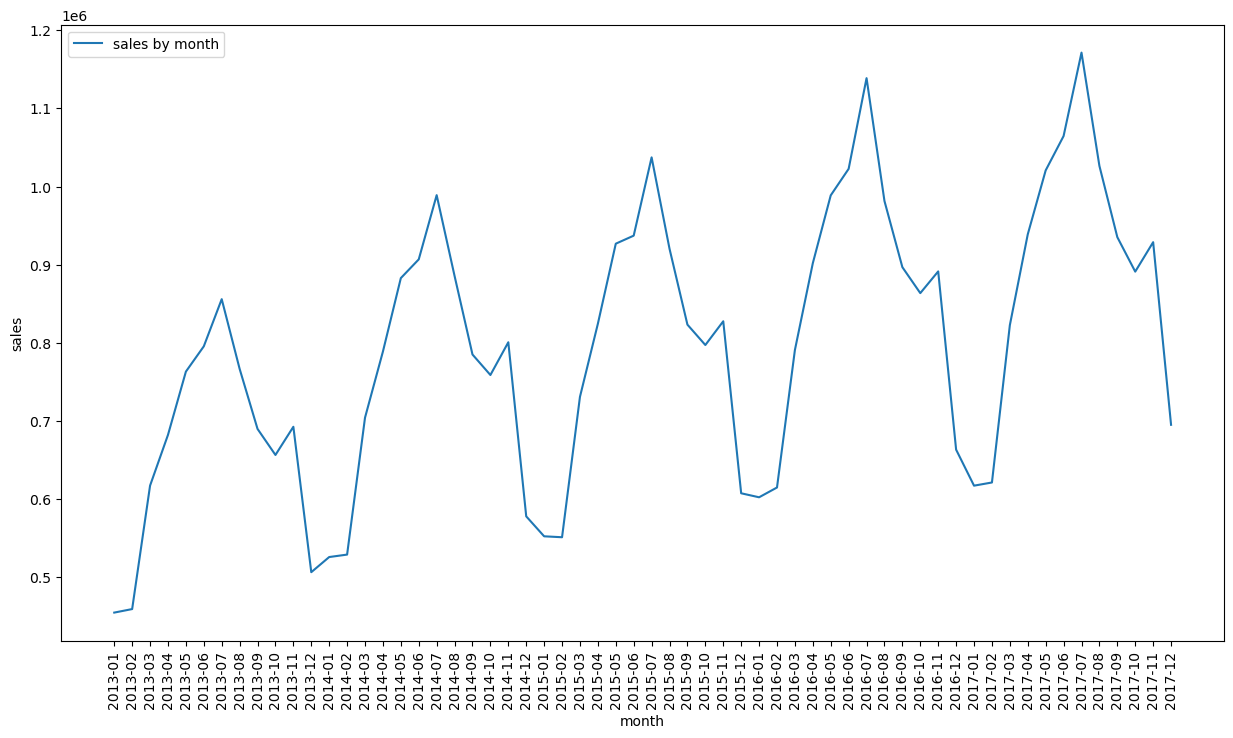

In [13]:
# Total Sales Trend By Month
x = list(df['month'].unique())
y_array = df[['sales','month']].groupby('month').sum().values
y = [i for item in y_array for i in item]
m_rate = []
for i in range(len(y)-1):
    m_rate.append(round(y[i+1]/y[i],3))
plt.figure(figsize=(15,8))
plt.plot(x,y,label='sales by month')
plt.xticks(rotation=90)
plt.legend()
plt.xlabel('month')
plt.ylabel('sales')
plt.show()

From the plot, we can see the sales is always highest of the year at July, which may caused by summer vacation. In addition, during November, there is a small peak caused by Thanks' Giving Day.

## Growth rate

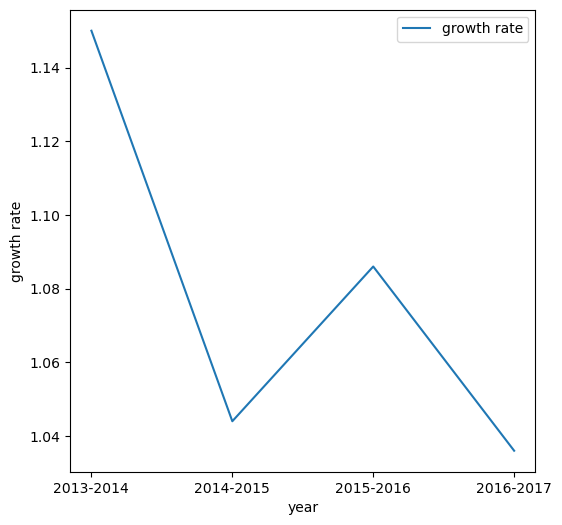

In [17]:
# Total Growth Rate By Year
plt.figure(figsize=(6,6))
plt.plot(['2013-2014','2014-2015','2015-2016','2016-2017'],y_rate,label='growth rate')
plt.legend()
plt.xlabel('year')
plt.ylabel('growth rate')
plt.show()

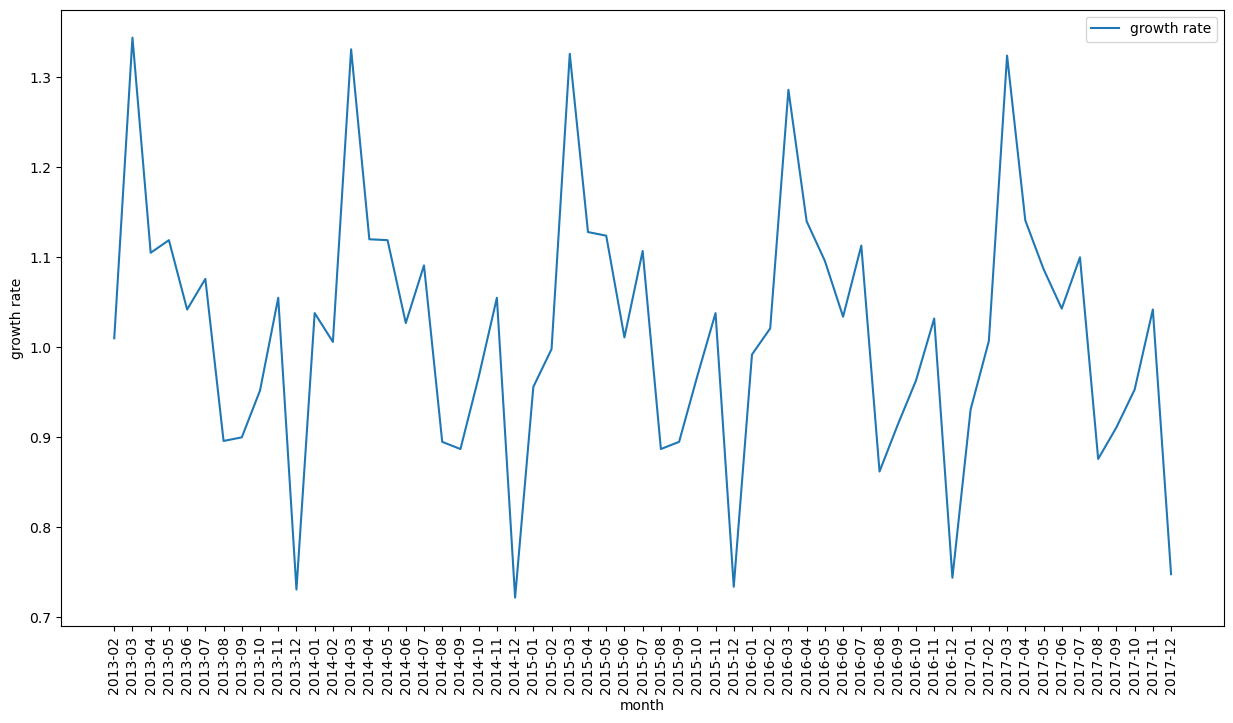

In [16]:
# Total Growth Rate By Month
plt.figure(figsize=(15,8))
plt.plot(list(df['month'].unique())[1:],m_rate,label='growth rate')
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('month')
plt.ylabel('growth rate')
plt.show()

# 2 How is the sales trend by different stores?

## Each line represents a store's sales trend over the 5 years

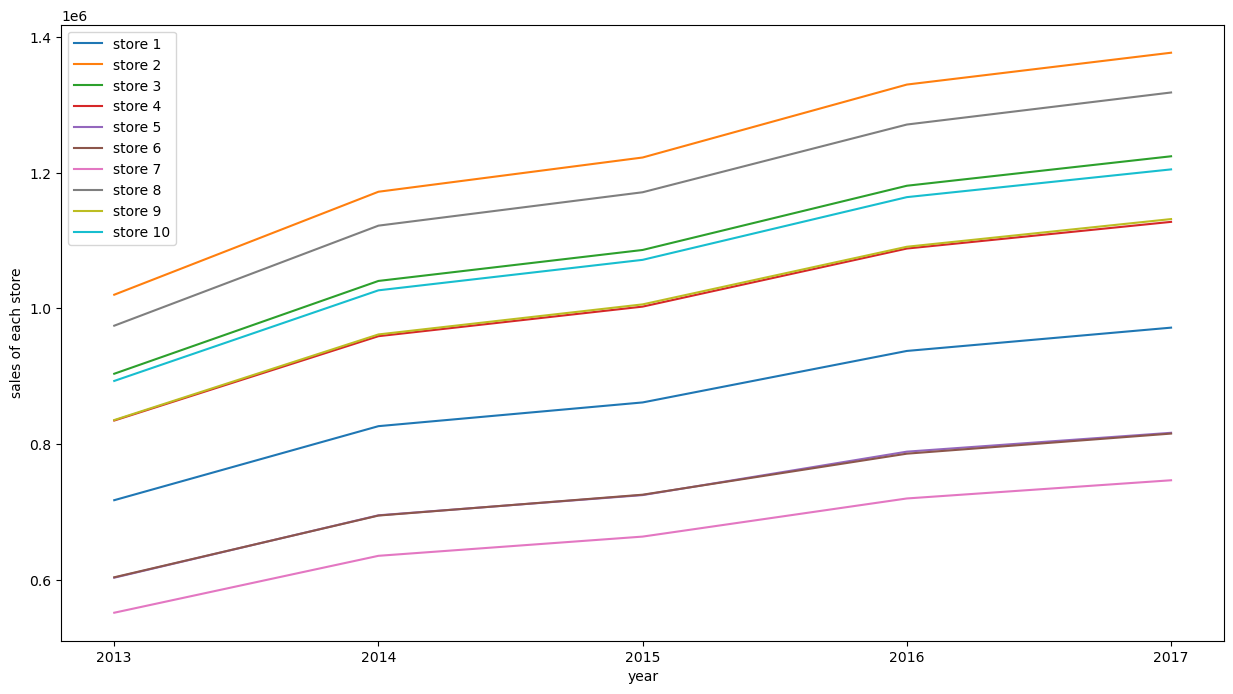

In [19]:
# Sales Trend For Each Store By Year
x = list(df['year'].unique())
stores = list(df['store'].unique())
y_growth_rate = {}
plt.figure(figsize=(15,8))
for i in stores:
    y_array = df.loc[df['store'] == i][['year','sales']].groupby('year').sum().values
    y = [i for item in y_array for i in item]
    y_rate = [round(y[1]/y[0],3),round(y[2]/y[1],3),round(y[3]/y[2],3),round(y[4]/y[3],3)]
    y_growth_rate[i] = y_rate
    plt.plot(x,y,label = 'store '+ str(i))
plt.legend()
plt.xlabel('year')
plt.ylabel('sales of each store')
plt.show()

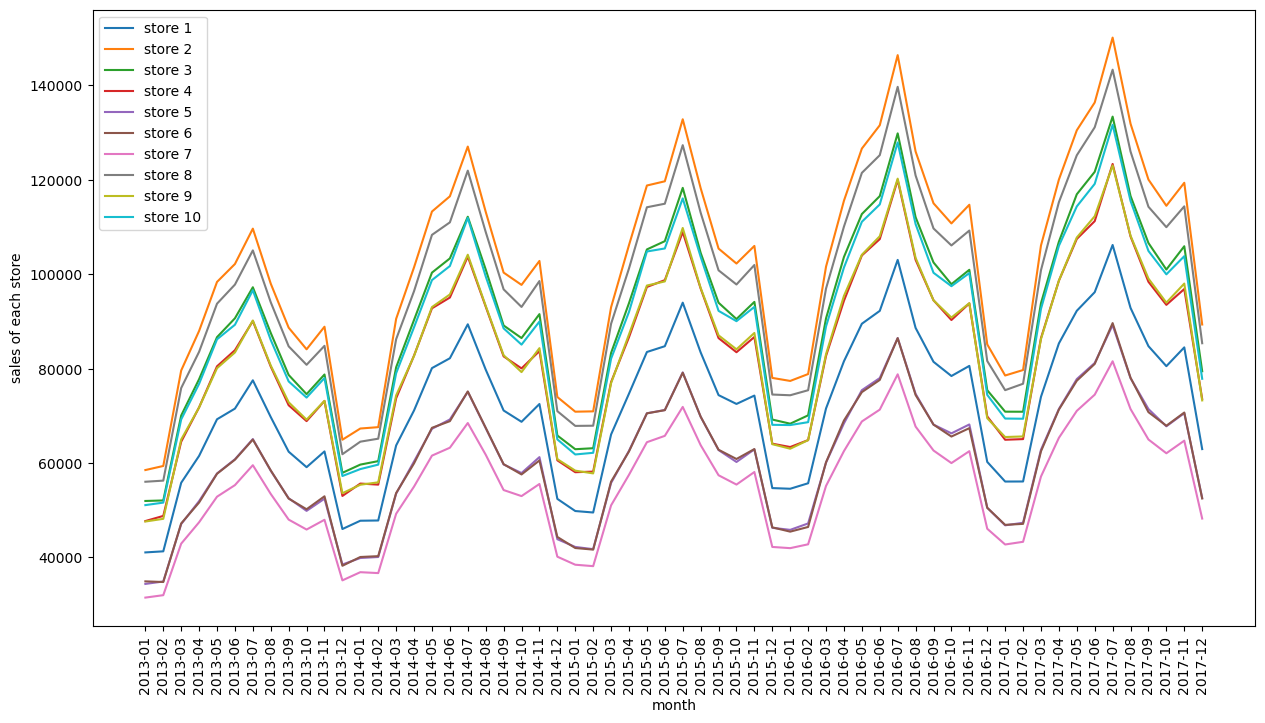

In [20]:
# Sales Trend For Each Store By Month
x = list(df['month'].unique())
stores = list(df['store'].unique())
m_growth_rate = {}
plt.figure(figsize=(15,8))
for i in stores:
    y_array = df.loc[df['store'] == i][['month','sales']].groupby('month').sum().values
    y = [i for item in y_array for i in item]
    m_rate = []
    for j in range(len(y)-1):
        m_rate.append(round(y[j+1]/y[j],3))
    m_growth_rate[i] = m_rate
    plt.plot(x,y,label = 'store '+ str(i))
plt.xticks(rotation=90)
plt.legend()
plt.xlabel('month')
plt.ylabel('sales of each store')
plt.show()

## Each row shows the growth rate of that store over the 5 years

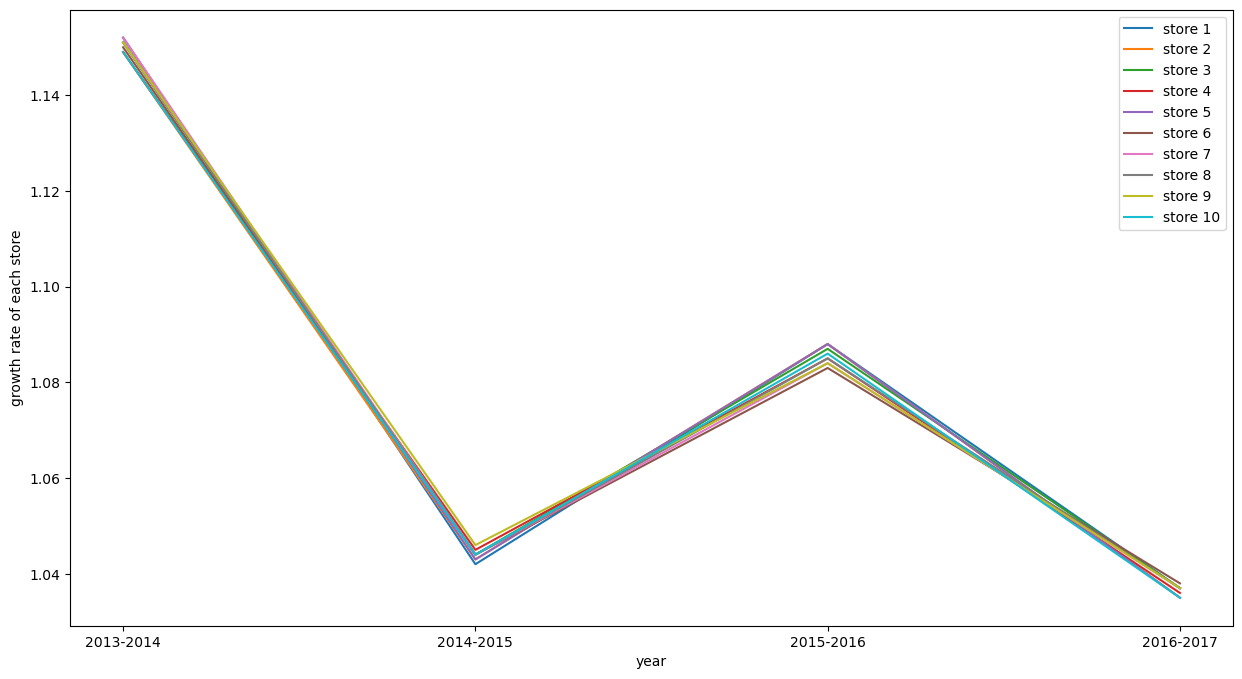

In [22]:
# Growth Rate For Each Store By Year
s_gr_df = pd.DataFrame(y_growth_rate)

# transposition
s_growth_rate_df = pd.DataFrame(s_gr_df.values.T, index=s_gr_df.columns, 
                              columns=['2013-2014','2014-2015','2015-2016','2016-2017'])

# plot
x = ['2013-2014','2014-2015','2015-2016','2016-2017']
plt.figure(figsize=(15,8))
for i in s_growth_rate_df.index:
    y_array = s_growth_rate_df.iloc[i-1].values
    plt.plot(x,y_array,label = 'store '+ str(i))
plt.legend()
plt.xlabel('year')
plt.ylabel('growth rate of each store')
plt.show()

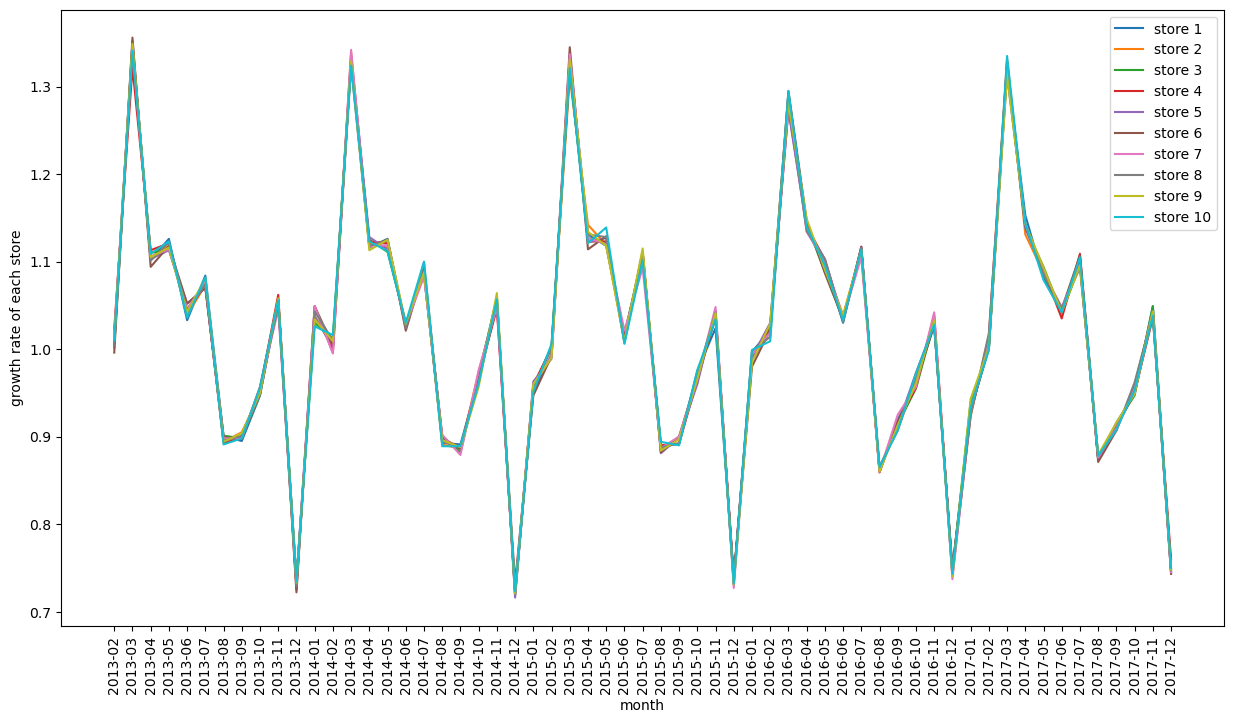

In [23]:
# Growth Rate For Each Store By Month
s_gr_df = pd.DataFrame(m_growth_rate)

# transposition
s_growth_rate_df = pd.DataFrame(s_gr_df.values.T, index=s_gr_df.columns, 
                              columns= list(df['month'].unique())[1:])

# plot
x = list(df['month'].unique())[1:]
plt.figure(figsize=(15,8))
for i in s_growth_rate_df.index:
    y_array = s_growth_rate_df.iloc[i-1].values
    plt.plot(x,y_array,label = 'store '+ str(i))
plt.xticks(rotation=90)
plt.legend()
plt.xlabel('month')
plt.ylabel('growth rate of each store')
plt.show()

# 3 How is the sales trend by different items?

## Each line represents an item's sales trend over the 5 years

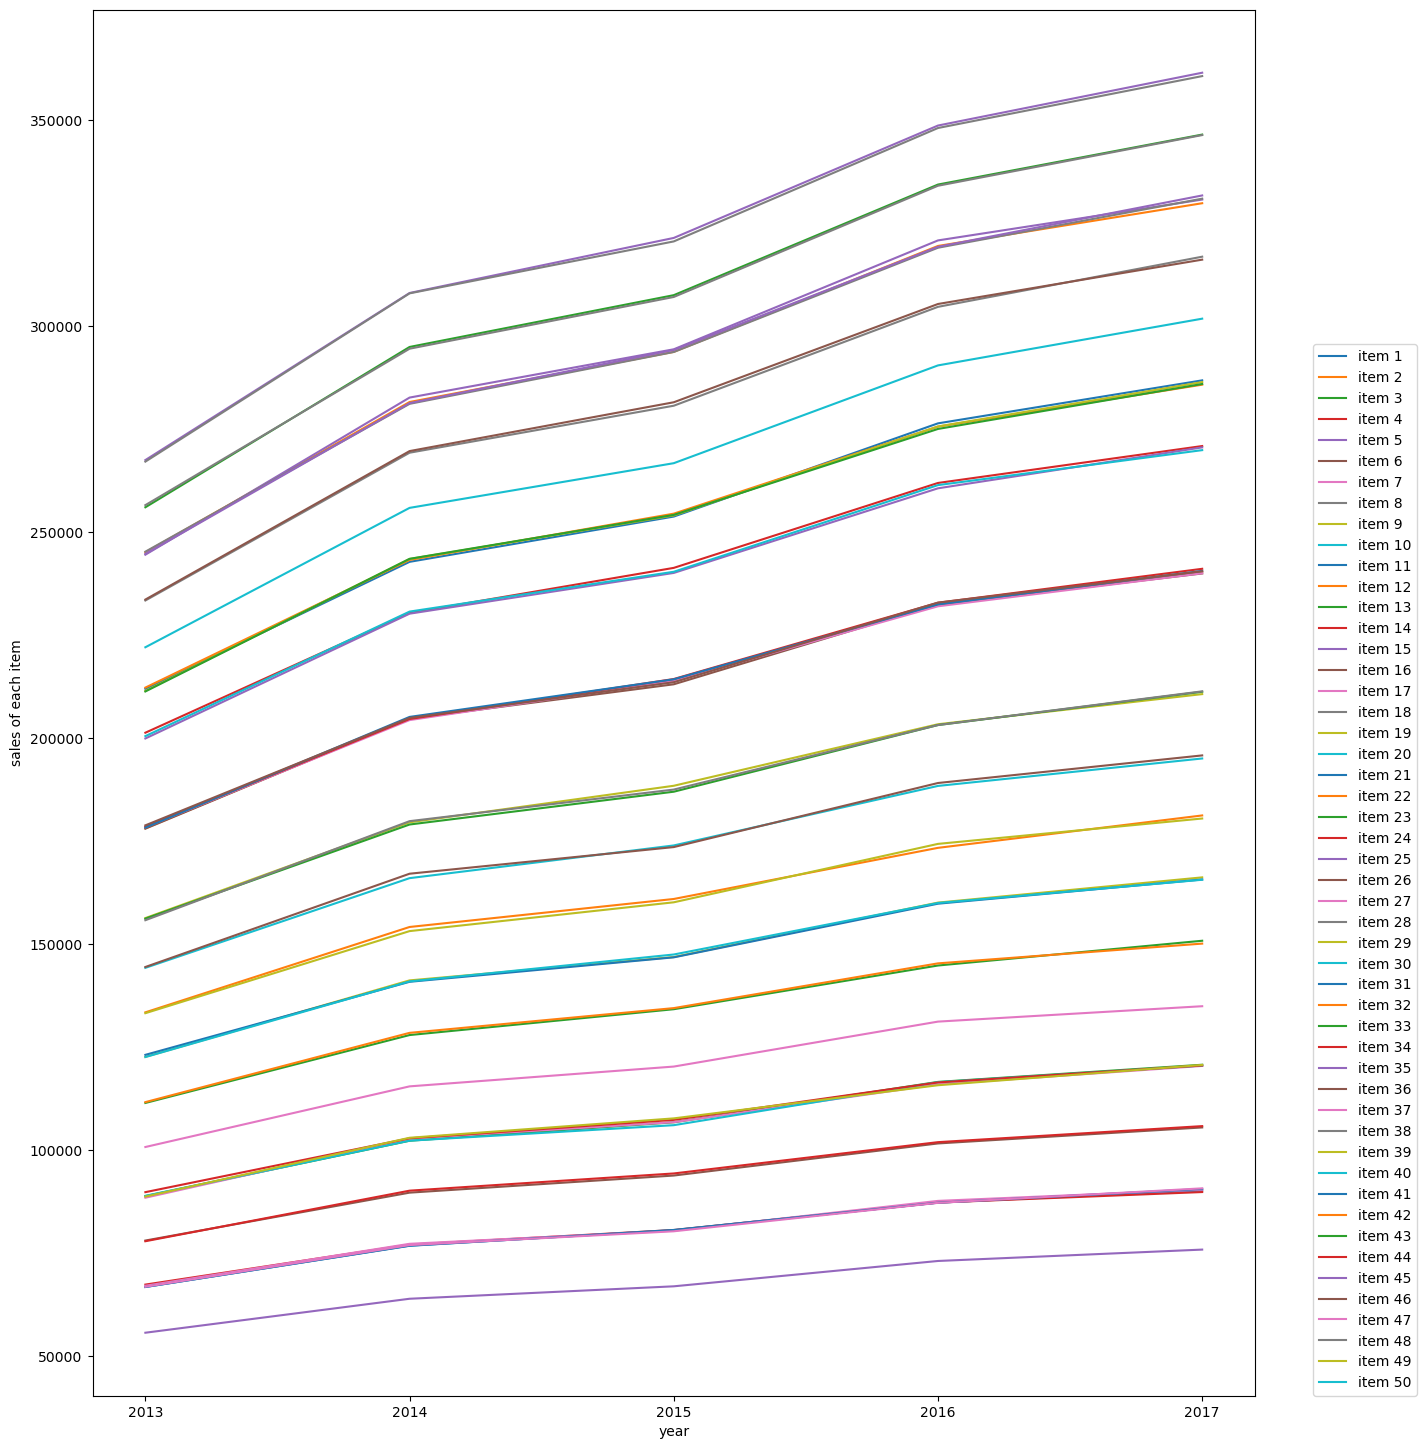

In [24]:
# Sales Trend For Each Item By Year
x = list(df['year'].unique())
items = list(df['item'].unique())
y_growth_rate = {}
plt.figure(figsize=(15,18))
for i in items:
    y_array = df.loc[df['item'] == i][['year','sales']].groupby('year').sum().values
    y = [i for item in y_array for i in item]
    y_rate = [round(y[1]/y[0],3),round(y[2]/y[1],3),round(y[3]/y[2],3),round(y[4]/y[3],3)]
    y_growth_rate[i] = y_rate
    plt.plot(x,y,label = 'item '+ str(i))
plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
plt.xlabel('year')
plt.ylabel('sales of each item')
plt.show()

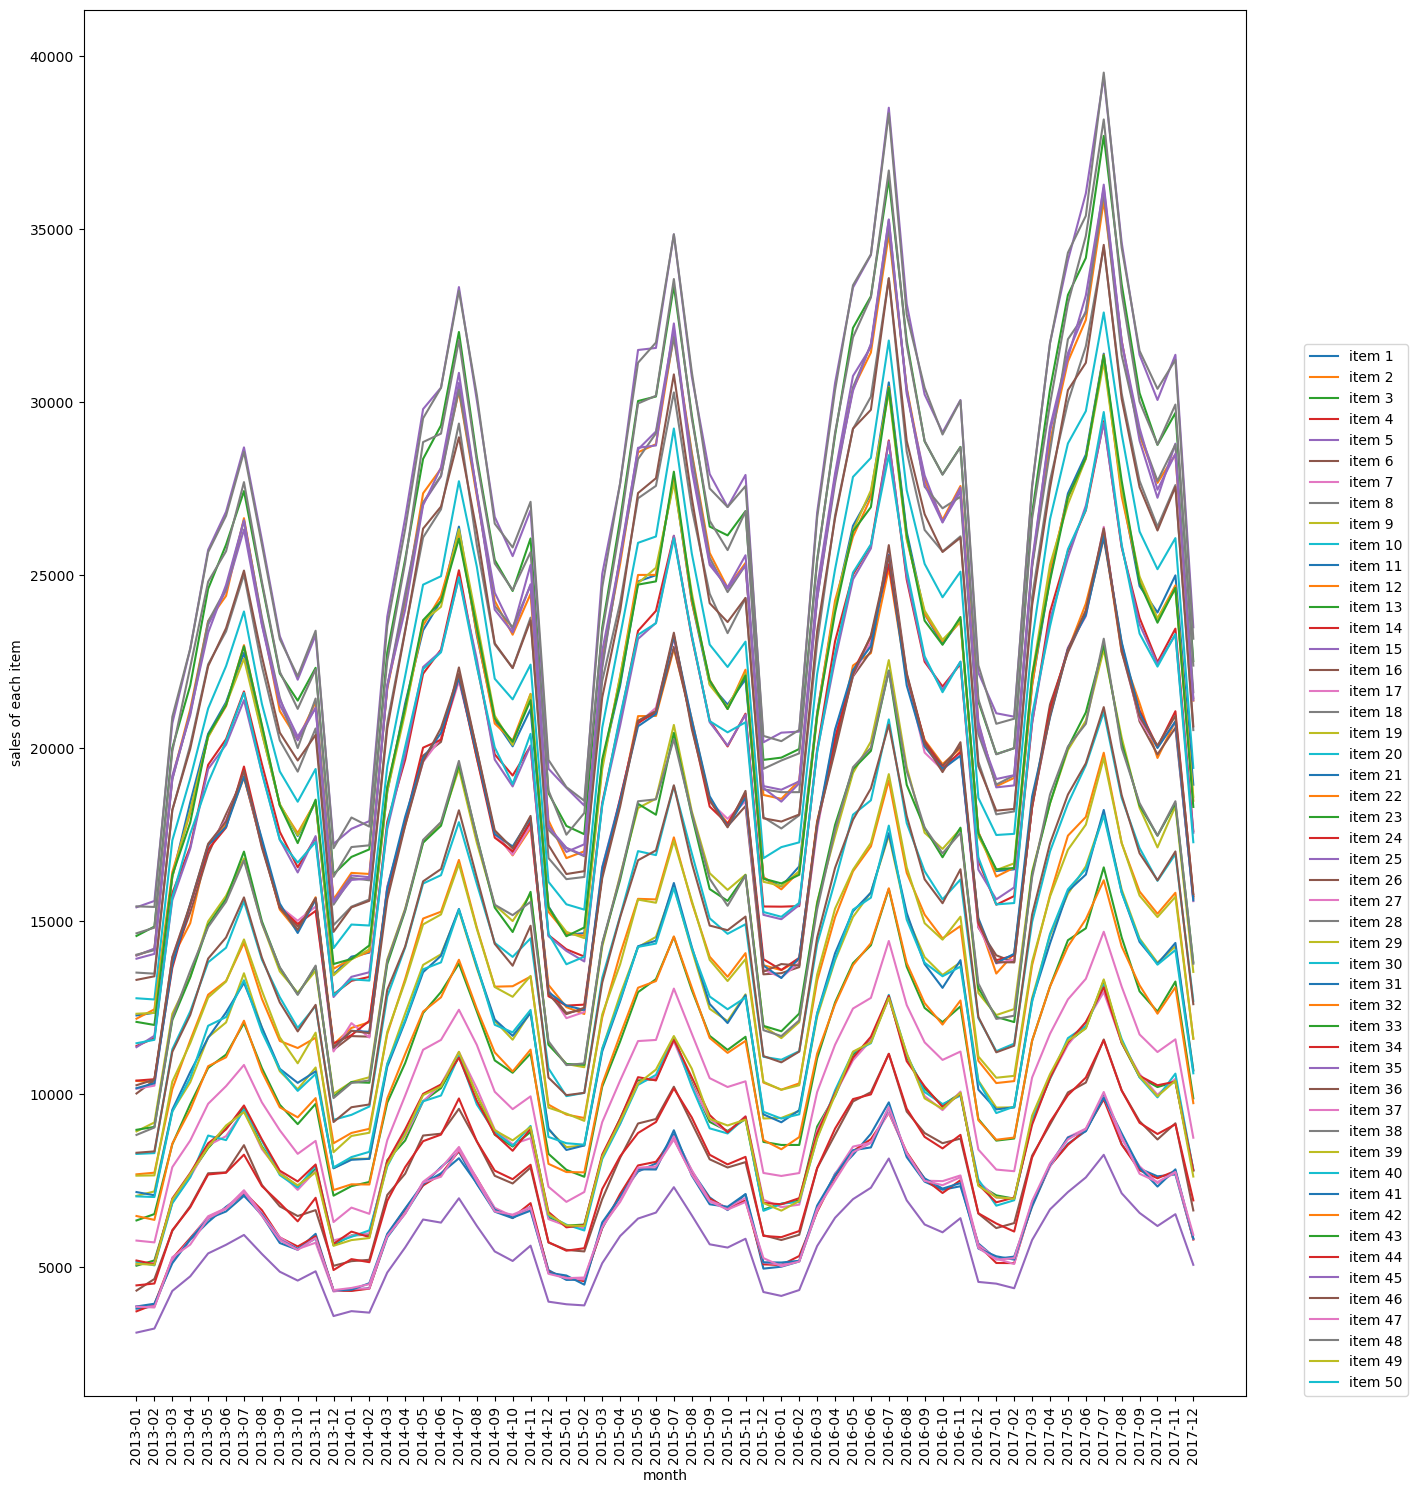

In [27]:
# Sales Trend For Each Item By Month
x = list(df['month'].unique())
items = list(df['item'].unique())
m_growth_rate = {}
plt.figure(figsize=(15,18))
for i in items:
    y_array = df.loc[df['item'] == i][['month','sales']].groupby('month').sum().values
    y = [i for item in y_array for i in item]
    m_rate = []
    for j in range(len(y)-1):
        m_rate.append(round(y[j+1]/y[j],3))
    m_growth_rate[i] = m_rate
    plt.plot(x,y,label = 'item '+ str(i))
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
plt.xlabel('month')
plt.ylabel('sales of each item')
plt.show()

## Each row shows the growth rate of that item over the 5 years

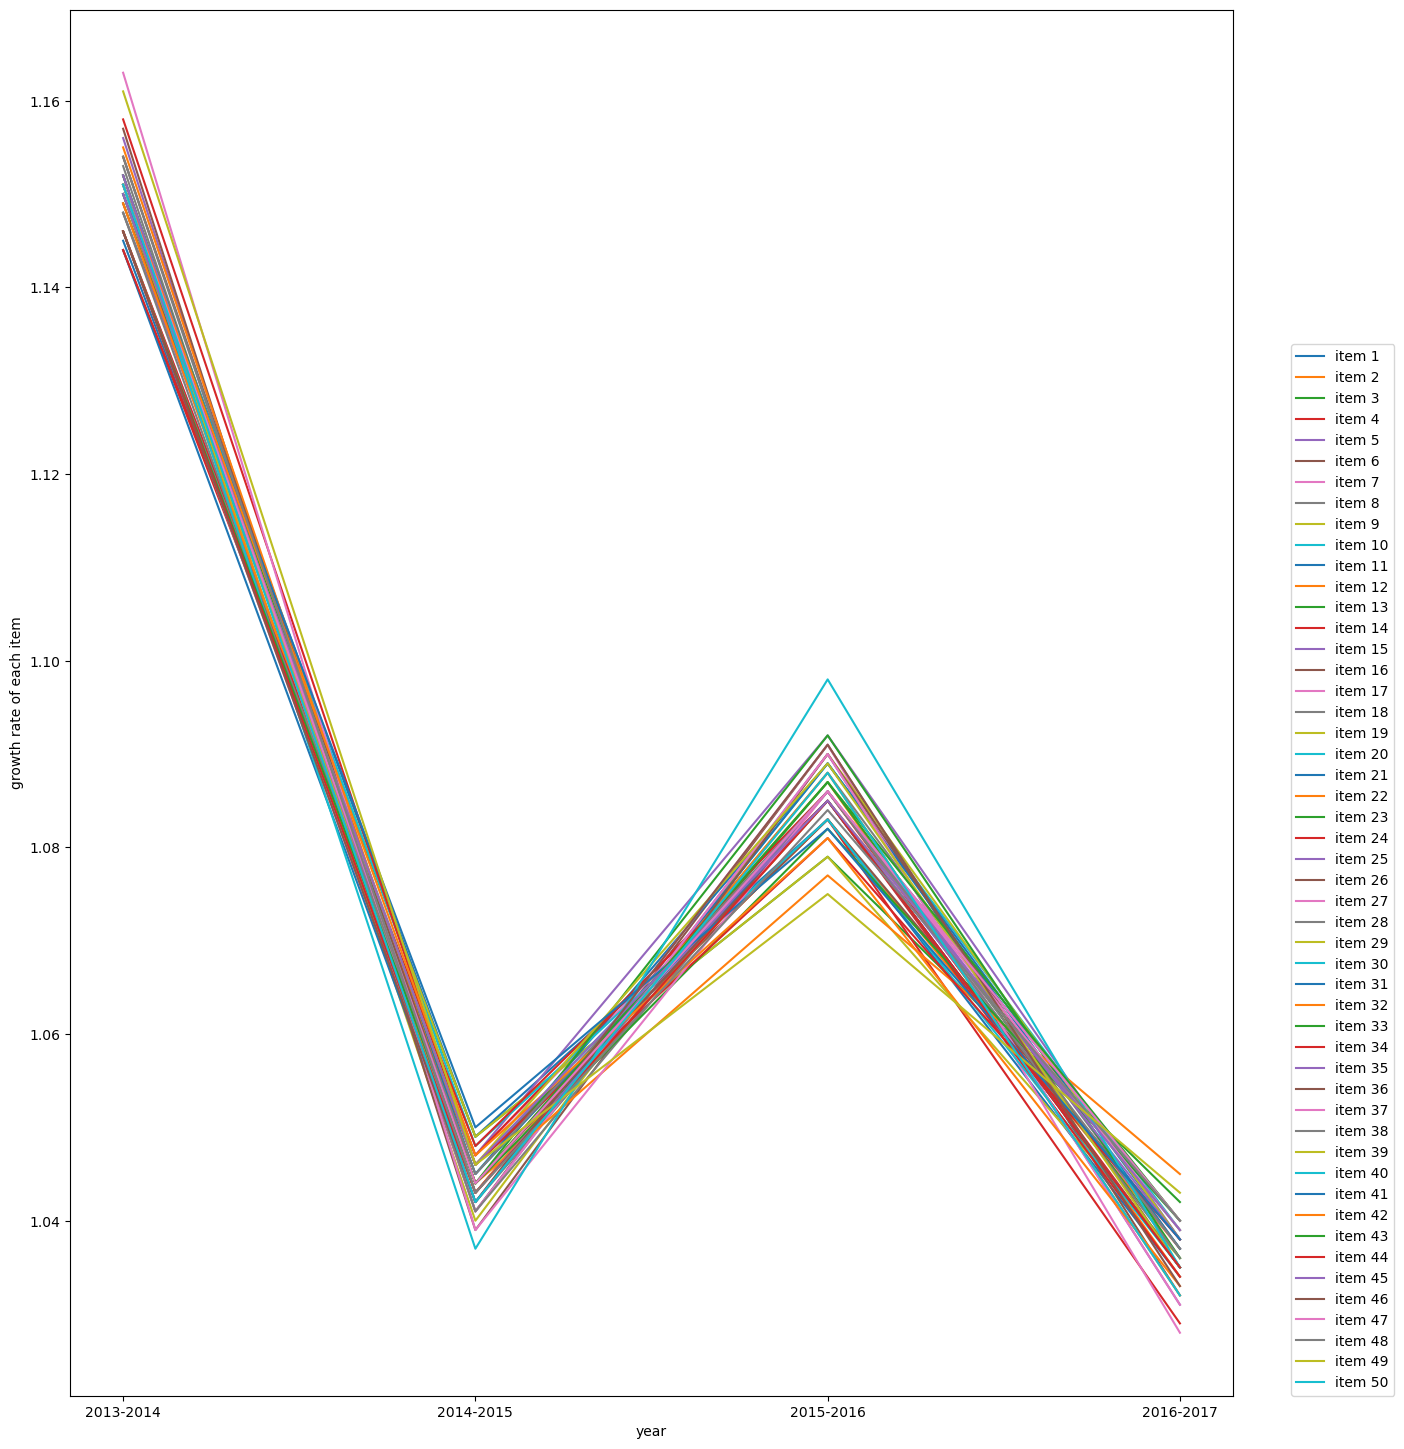

In [29]:
# Growth Rate For Each Item By Year
s_gr_df = pd.DataFrame(y_growth_rate)

# transposition
s_growth_rate_df = pd.DataFrame(s_gr_df.values.T, index=s_gr_df.columns, 
                              columns=['2013-2014','2014-2015','2015-2016','2016-2017'])

# plot
x = ['2013-2014','2014-2015','2015-2016','2016-2017']
plt.figure(figsize=(15,18))
for i in s_growth_rate_df.index:
    y_array = s_growth_rate_df.iloc[i-1].values
    plt.plot(x,y_array,label = 'item '+ str(i))
plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
plt.xlabel('year')
plt.ylabel('growth rate of each item')
plt.show()

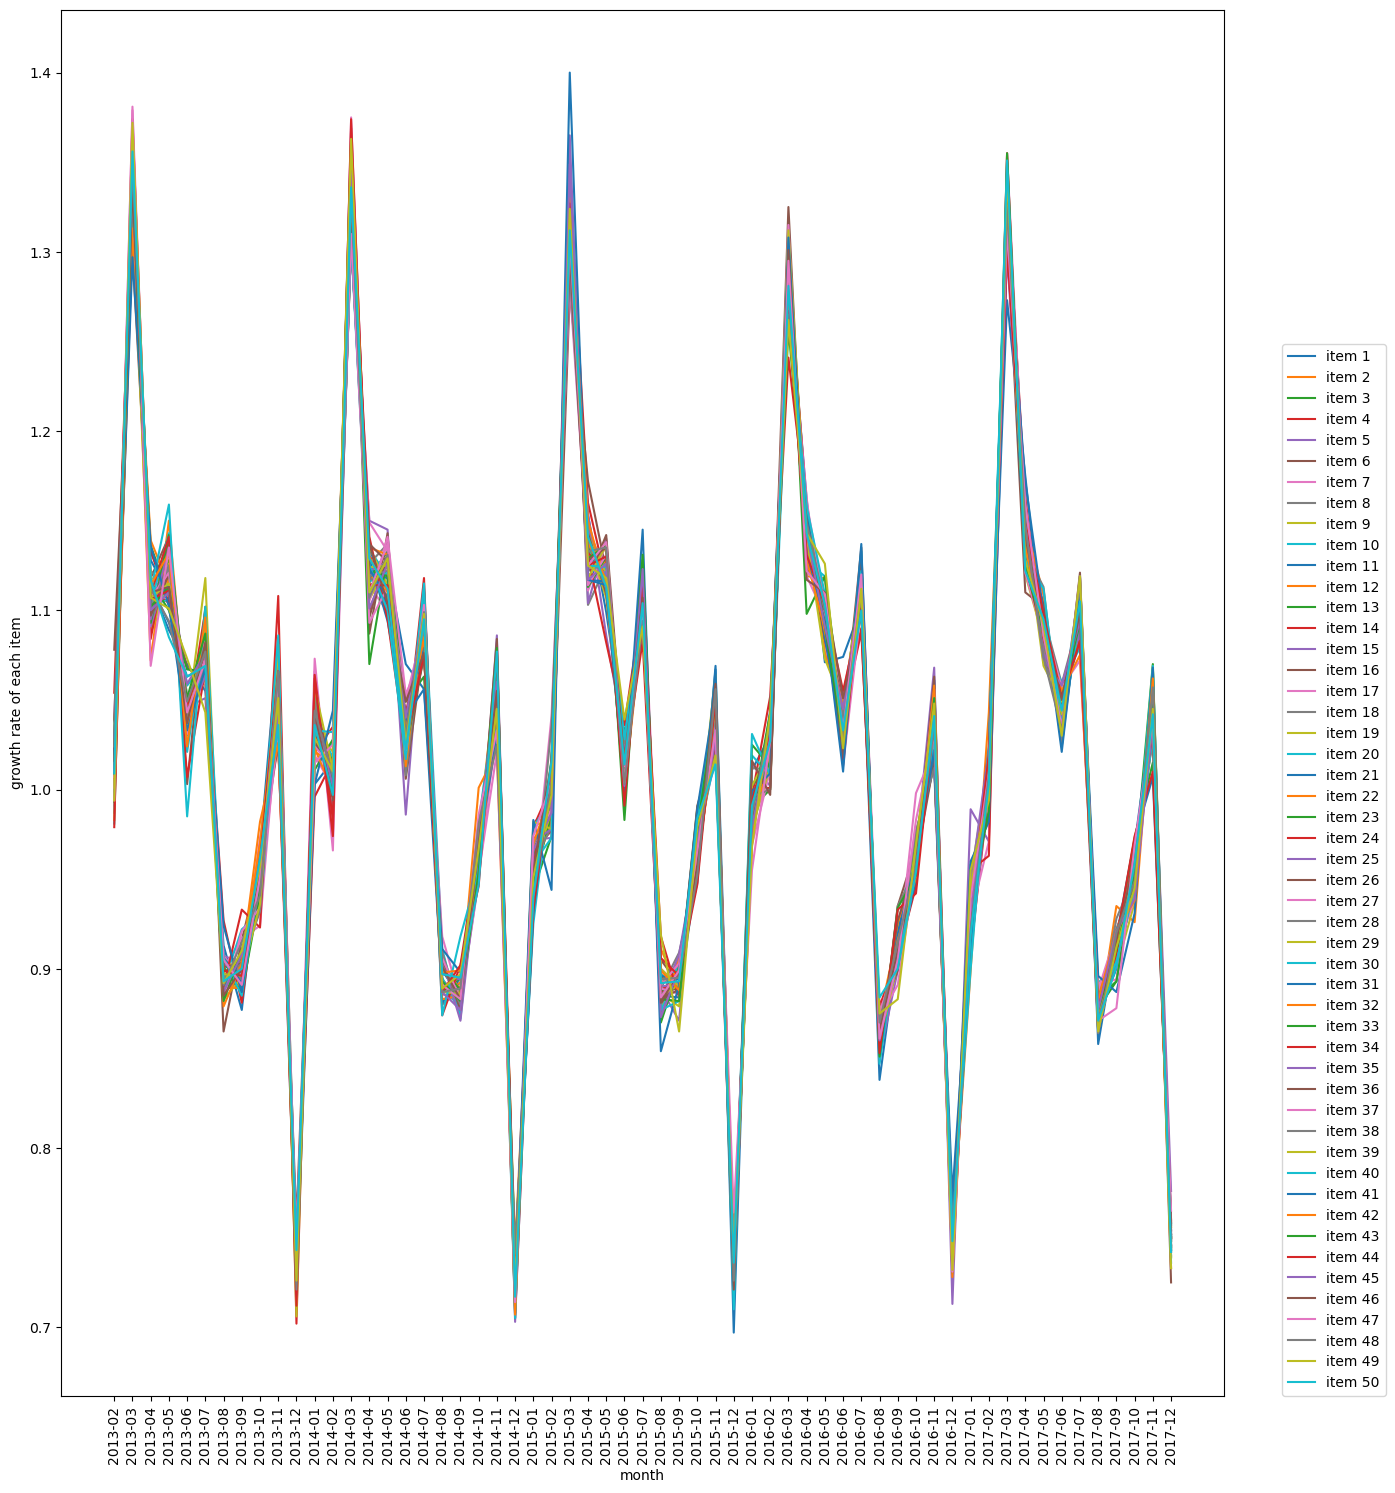

In [30]:
# Growth Rate For Each Item By Month
s_gr_df = pd.DataFrame(m_growth_rate)

# transposition
s_growth_rate_df = pd.DataFrame(s_gr_df.values.T, index=s_gr_df.columns, 
                              columns= list(df['month'].unique())[1:])

# plot
x = list(df['month'].unique())[1:]
plt.figure(figsize=(15,18))
for i in s_growth_rate_df.index:
    y_array = s_growth_rate_df.iloc[i-1].values
    plt.plot(x,y_array,label = 'item '+ str(i))
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
plt.xlabel('month')
plt.ylabel('growth rate of each item')
plt.show()

# 4 Do you have any recommendations for the growth of the stores?

All the 10 stores and the 50 items have similar sales trend, highest growth in 2015 compared to 2014, lower growth in 2015, then growth rate rises a little bit in 2016, but fall to lowest in 2017. This may indicates the growth is influenced by the whole economic environment and the market.
In addition, the time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the middle(festive season maybe) of the year and again low at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.
For the stores, there may not much thing they can do. However, they can always find some way to make the sales growth become better, such as increasing sales opportunities, improving customer service, adding new products or product lines, etc.

# 5 Bonus: predict 3 months of sales for these 50 different items at 10 stores

In [31]:
df_month = df[['month','store','item','sales']].groupby(['month','store','item']).sum().reset_index()
df_month

month  store  item  sales
0      2013-01      1     1    328
1      2013-01      1     2    911
2      2013-01      1     3    547
3      2013-01      1     4    346
4      2013-01      1     5    276
...        ...    ...   ...    ...
29995  2017-12     10    46   1723
29996  2017-12     10    47    626
29997  2017-12     10    48   1537
29998  2017-12     10    49    815
29999  2017-12     10    50   1987

[30000 rows x 4 columns]

## 5.1 Determining Stationarity
Stationarity can be defined in precise mathematical terms, but for our purpose we mean a flat looking series, without trend, constant variance over time, a constant autocorrelation structure over time and no periodic fluctuations (seasonality)

In [32]:
# create DataFrame for monthly sales
def monthly_sales(data):
    monthly_data = data.copy()
    monthly_data.date = monthly_data.date.apply(lambda x: str(x)[:-3])
    monthly_data = monthly_data.groupby('date')['sales'].sum().reset_index()
    monthly_data.date = pd.to_datetime(monthly_data.date)
    return monthly_data


monthly_df = monthly_sales(data)
monthly_df.head()

date   sales
0 2013-01-01  454904
1 2013-02-01  459417
2 2013-03-01  617382
3 2013-04-01  682274
4 2013-05-01  763242

C:\Users\zhang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\zhang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


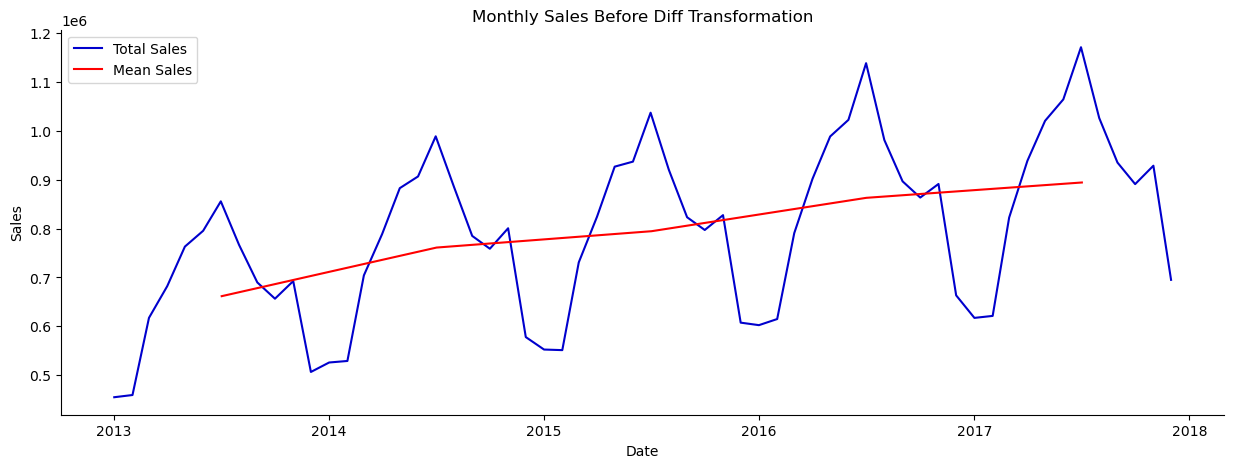

In [33]:
# Plot the sales of every month and mean of every year to determine stationary
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax, color='mediumblue', label='Total Sales')
    
    second = data.groupby(data.date.dt.year)[y_col].mean().reset_index()
    second.date = pd.to_datetime(second.date, format='%Y')
    sns.lineplot((second.date + datetime.timedelta(6*365/12)), y_col, data=second, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = title)
    
    sns.despine()
    
time_plot(monthly_df, 'date', 'sales', 'Monthly Sales Before Diff Transformation')

The plot clearly shows that the sales is unstable, along with its obvious seasonality.

C:\Users\zhang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\zhang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


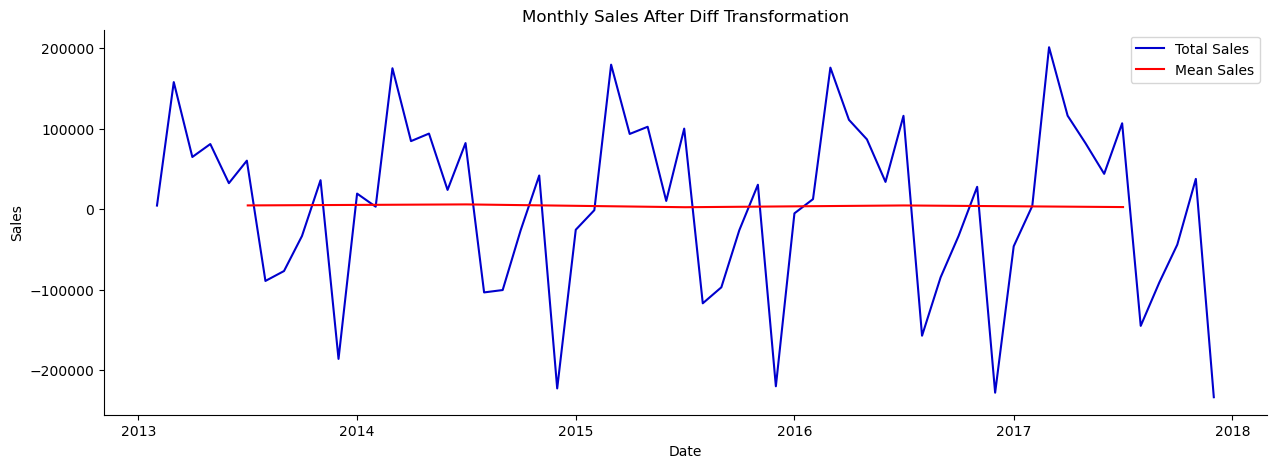

In [34]:
# Calculate the difference between every neighbor two months
def get_diff(data):
    data['sales_diff'] = data.sales.diff()
    data = data.dropna()
    return data

stationary_df = get_diff(monthly_df)
time_plot(stationary_df, 'date', 'sales_diff', 'Monthly Sales After Diff Transformation')

The plot clearly shows that the sale difference is stationary.

## 5.2 Feature Engineering

Now we can start building our feature set. We need to use previous monthly sales data to forecast the next ones. The look-back period (lag period) may vary for every model. Ours will be 12 for this example.

Different models may need different feature.

### 5.2.1 For Regressive Modeling

In [35]:
# Create dataframe for transformation from time series to supervised
def generate_supervised(data):
    supervised_df = data.copy()
    
    #create column for each lag
    for i in range(1,13):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['sales_diff'].shift(i)
    
    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)
    
    return supervised_df


model_df = generate_supervised(stationary_df)
model_df.head()

date   sales  sales_diff     lag_1     lag_2     lag_3     lag_4  \
0 2014-02-01  529117      3130.0   19380.0 -186036.0   36056.0  -33320.0   
1 2014-03-01  704301    175184.0    3130.0   19380.0 -186036.0   36056.0   
2 2014-04-01  788914     84613.0  175184.0    3130.0   19380.0 -186036.0   
3 2014-05-01  882877     93963.0   84613.0  175184.0    3130.0   19380.0   
4 2014-06-01  906842     23965.0   93963.0   84613.0  175184.0    3130.0   

      lag_5     lag_6    lag_7    lag_8    lag_9   lag_10    lag_11    lag_12  
0  -76854.0  -89161.0  60325.0  32355.0  80968.0  64892.0  157965.0    4513.0  
1  -33320.0  -76854.0 -89161.0  60325.0  32355.0  80968.0   64892.0  157965.0  
2   36056.0  -33320.0 -76854.0 -89161.0  60325.0  32355.0   80968.0   64892.0  
3 -186036.0   36056.0 -33320.0 -76854.0 -89161.0  60325.0   32355.0   80968.0  
4   19380.0 -186036.0  36056.0 -33320.0 -76854.0 -89161.0   60325.0   32355.0

### 5.2.2 For ARIMA Modeling

In [36]:
def generate_arima_data(data):
    dt_data = data.set_index('date').drop('sales', axis=1)
    dt_data.dropna(axis=0)
    
    return dt_data


arima_df = generate_arima_data(stationary_df)
arima_df

sales_diff
date                  
2013-02-01      4513.0
2013-03-01    157965.0
2013-04-01     64892.0
2013-05-01     80968.0
2013-06-01     32355.0
2013-07-01     60325.0
2013-08-01    -89161.0
2013-09-01    -76854.0
2013-10-01    -33320.0
2013-11-01     36056.0
2013-12-01   -186036.0
2014-01-01     19380.0
2014-02-01      3130.0
2014-03-01    175184.0
2014-04-01     84613.0
2014-05-01     93963.0
2014-06-01     23965.0
2014-07-01     82168.0
2014-08-01   -103414.0
2014-09-01   -100472.0
2014-10-01    -26241.0
2014-11-01     41900.0
2014-12-01   -222735.0
2015-01-01    -25535.0
2015-02-01     -1196.0
2015-03-01    179634.0
2015-04-01     93516.0
2015-05-01    102435.0
2015-06-01     10282.0
2015-07-01    100166.0
2015-08-01   -116949.0
2015-09-01    -97069.0
2015-10-01    -26079.0
2015-11-01     30392.0
2015-12-01   -220073.0
2016-01-01     -5133.0
2016-02-01     12518.0
2016-03-01    175924.0
2016-04-01    111069.0
2016-05-01     86780.0
2016-06-01     33934.0
2016-07-01    116054.0
2016-08-01   -157224.0
2016-09-01    -84663.0
2016-10-01    -33194.0
2016-11-01     27811.0
2016-12-01   -228037.0
2017-01-01    -46105.0
2017-02-01      4063.0
2017-03-01    201298.0
2017-04-01    116195.0
2017-05-01     81824.0
2017-06-01     43938.0
2017-07-01    106769.0
2017-08-01   -144990.0
2017-09-01    -91140.0
2017-10-01    -44103.0
2017-11-01     37677.0
2017-12-01   -233667.0

## 5.3 Modeling

In [37]:
def tts(data):
    data = data.drop(['sales','date'],axis=1)
    train, test = data[0:-3].values, data[-3:].values
    
    return train, test

train, test = tts(model_df)

### 5.3.1 Regressive model

In [38]:
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)

In [39]:
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

In [40]:
def load_original_df():
    #load in original dataframe without scaling applied
    original_df = data.copy()
    original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('date')['sales'].sum().reset_index()
    original_df.date = pd.to_datetime(original_df.date)
    return original_df

In [41]:
def predict_df(unscaled_predictions, original_df):
    # create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-4:].date)
    act_sales = list(original_df[-4:].sales)
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result

In [42]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df.sales[-3:], unscaled_df.pred_value[-3:]))
    mae = mean_absolute_error(original_df.sales[-3:], unscaled_df.pred_value[-3:])
    r2 = r2_score(original_df.sales[-3:], unscaled_df.pred_value[-3:])
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

In [43]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax, 
                 label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()

In [44]:
def run_model(train_data, test_data, model, model_name):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    
    # Undo scaling to compare predictions against original data
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, original_df)
      
    get_scores(unscaled_df, original_df, model_name)
    
    plot_results(unscaled_df, original_df, model_name)

#### 5.3.1. a)  Linear Regression

RMSE: 13034.26302737008
MAE: 10832.0
R2 Score: 0.9838081404665647


C:\Users\zhang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\zhang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


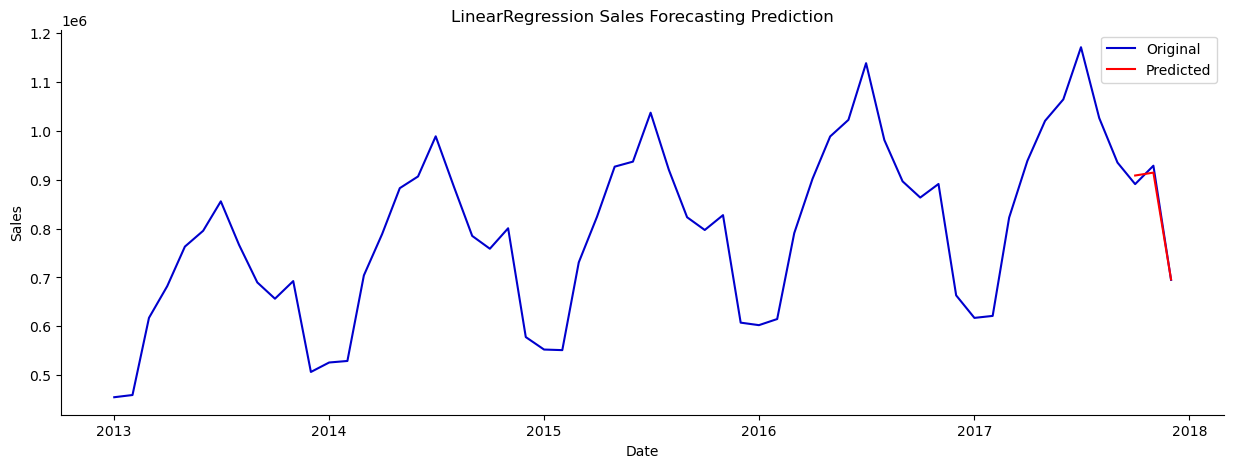

In [45]:
run_model(train, test, LinearRegression(), 'LinearRegression')

#### 5.3.1. b)  LSTM

In [46]:
def lstm_model(train_data, test_data):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
   
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), 
                   stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, 
              shuffle=False)
    predictions = model.predict(X_test,batch_size=1)
    
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object, lstm=True)
    unscaled_df = predict_df(unscaled, original_df)
    
    get_scores(unscaled_df, original_df, 'LSTM')
    
    plot_results(unscaled_df, original_df, 'LSTM')

Epoch 1/200
44/44 [==============================] - 2s 2ms/step - loss: 0.2602 
Epoch 2/200
44/44 [==============================] - 0s 2ms/step - loss: 0.2268
Epoch 3/200
44/44 [==============================] - 0s 2ms/step - loss: 0.1998
Epoch 4/200
44/44 [==============================] - 0s 2ms/step - loss: 0.1757
Epoch 5/200
44/44 [==============================] - 0s 2ms/step - loss: 0.1542
Epoch 6/200
44/44 [==============================] - 0s 2ms/step - loss: 0.1353
Epoch 7/200
44/44 [==============================] - 0s 2ms/step - loss: 0.1188
Epoch 8/200
44/44 [==============================] - 0s 2ms/step - loss: 0.1044
Epoch 9/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0916
Epoch 10/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0802
Epoch 11/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0700
Epoch 12/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0607
Epoch 13/200
44/44 [================

44/44 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 103/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 104/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 105/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 106/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 107/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 108/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 109/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 110/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 111/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 112/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 113/200
44/44 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 114/200
44/44 [=========

C:\Users\zhang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\zhang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


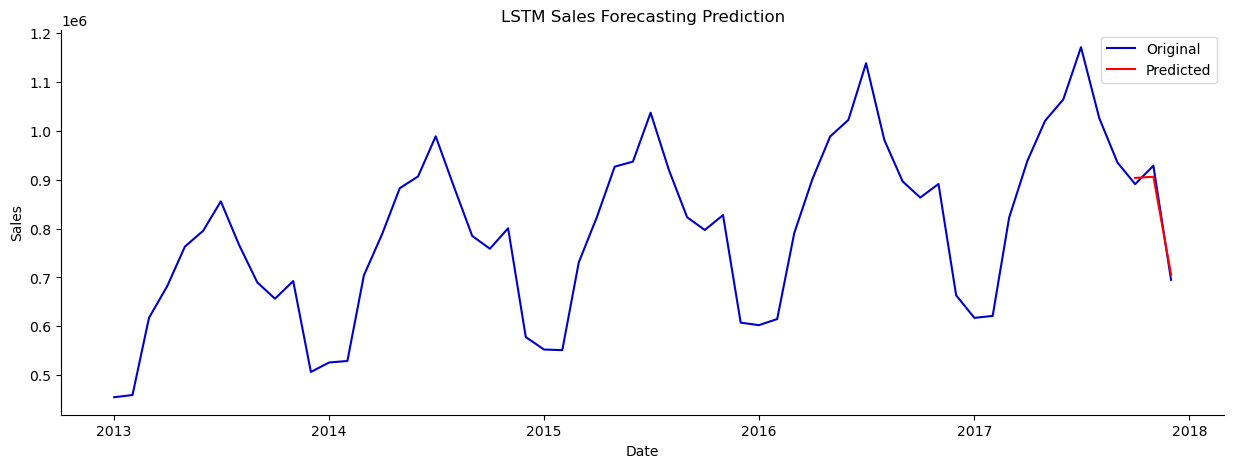

In [47]:
lstm_model(train, test)

In [48]:
pickle.dump(model_scores, open( "model_scores.p", "wb" ) )

### 5.3.2 ARIMA Model  (SARIMAX)
We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data.

* AR: Auto-Regressive (p): AR terms are just lags of dependent variable. For example lets say p is 3, we will use x(t-1), x(t-2) and x(t-3) to predict x(t)
* I: Integrated (d): These are the number of nonseasonal differences. 
* MA: Moving Averages (q): MA terms are lagged forecast errors in prediction equation.

In [49]:
ts_data = arima_df.copy()
ts_data.index = pd.to_datetime(ts_data.index)

In [50]:
def get_scores(data):
    
    model_scores = {}
    
    rmse = np.sqrt(mean_squared_error(data.sales_diff[-3:], data.forecast[-3:]))
    mae = mean_absolute_error(data.sales_diff[-3:], data.forecast[-3:])
    r2 = r2_score(data.sales_diff[-3:], data.forecast[-3:])
    model_scores['ARIMA'] = [rmse, mae, r2]
    
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")
    
    pickle.dump(model_scores, open( "arima_model_scores.p", "wb" ))

C:\Users\zhang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\zhang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RMSE: 6497.006328836726
MAE: 6108.717733873166
R2 Score: 0.9967320458096897


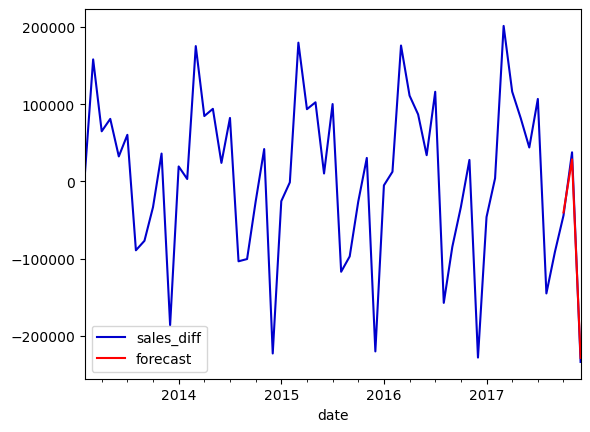

In [56]:
# predict sales_diff and plot
def sarimax_model(data):
    
    # Model
    sar = sm.tsa.statespace.SARIMAX(ts_data.sales_diff, order=(12,0,0), seasonal_order=(0,1,0,12), trend='c').fit()

    # Predictions
    start, end, dynamic = pd.to_datetime('2017-10-01'),pd.to_datetime('2017-12-01'), False
    data['forecast'] = sar.predict(start=start, end=end, dynamic=dynamic) 
    pred_df = data.forecast[start:end]
    
    data[['sales_diff', 'forecast']].plot(color=['mediumblue', 'Red'])
    
    get_scores(data)

    return sar, data, pred_df

sar, ts_data, predictions = sarimax_model(ts_data)

In [52]:
def predict_df(prediction_df):
    
    #load in original dataframe without scaling applied
    original_df = data.copy()
    original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('date')['sales'].sum().reset_index()
    original_df.date = pd.to_datetime(original_df.date)
    
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-4:].date)
    act_sales = list(original_df[-4:].sales)
    
    for index in range(0,len(prediction_df)):
        result_dict = {}
        result_dict['pred_value'] = int(prediction_df[index] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result, original_df

In [53]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax, 
                label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()

C:\Users\zhang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\zhang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


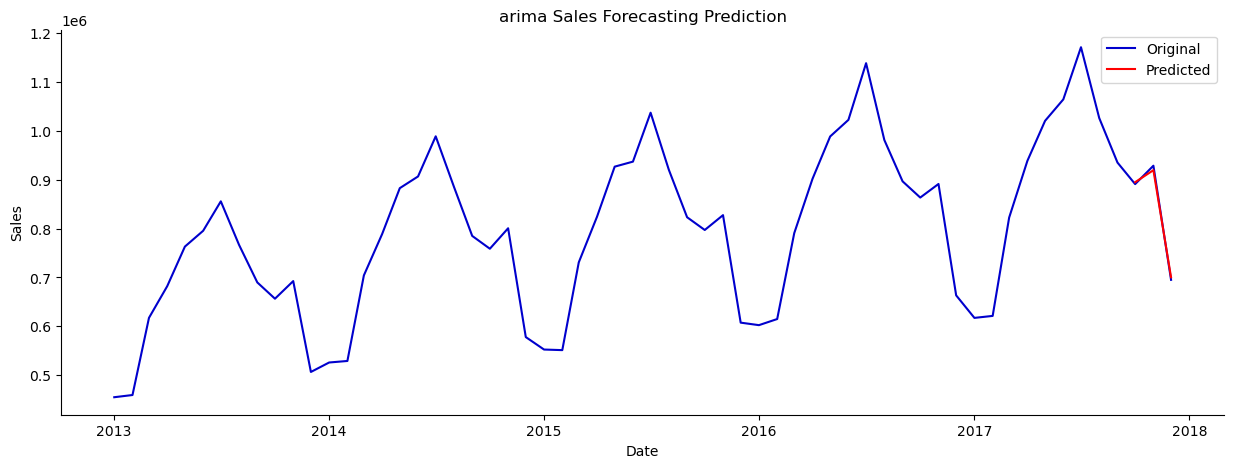

In [54]:
prediction_df, original_df = predict_df(predictions)
plot_results(prediction_df, original_df, 'arima')

We can also get dynamic predictions. One-step-ahead prediction uses the true values of the endogenous values at each step to predict the next in-sample value. Dynamic predictions use one-step-ahead prediction up to some point in the dataset (specified by the dynamic argument); after that, the previous predicted endogenous values are used in place of the true endogenous values for each new predicted element.

## 5.4 Model Selection

In [57]:
def create_results_df():
    results_dict = pickle.load(open("model_scores.p", "rb"))
    
    results_dict.update(pickle.load(open("arima_model_scores.p", "rb")))
    
    restults_df = pd.DataFrame.from_dict(results_dict, orient='index', 
                                        columns=['RMSE', 'MAE','R2'])
    
    restults_df = restults_df.sort_values(by='RMSE', ascending=False).reset_index()
    
    return restults_df

In [58]:
results = create_results_df()
results

index          RMSE           MAE        R2
0              LSTM  16179.395137  15333.666667  0.975051
1  LinearRegression  13034.263027  10832.000000  0.983808
2             ARIMA   6497.006329   6108.717734  0.996732

C:\Users\zhang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\zhang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


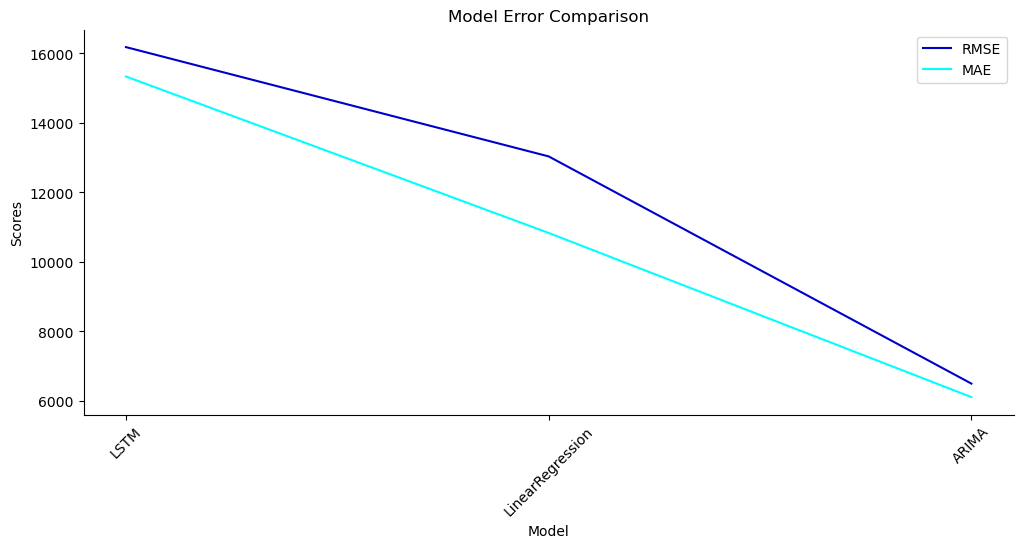

In [59]:
def plot_results(results_df):
    fig, ax = plt.subplots(figsize=(12, 5))
    sns.lineplot(np.arange(len(results_df)), 'RMSE', data=results_df, ax=ax, 
                 label='RMSE', color='mediumblue')
    sns.lineplot(np.arange(len(results_df)), 'MAE', data=results_df, ax=ax, 
                 label='MAE', color='Cyan')
    
    plt.xticks(np.arange(len(results_df)),rotation=45)
    ax.set_xticklabels(results_df['index'])
    ax.set(xlabel = "Model",
           ylabel = "Scores",
           title = "Model Error Comparison")
    sns.despine()
    

plot_results(results)